In [1]:
import os
import pandas as np
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from sklearn.model_selection import train_test_split

In [11]:
train_data_path='/content/drive/MyDrive/Alzheimer_s Dataset/train'
test_data_path='/content/drive/MyDrive/Alzheimer_s Dataset/test/'

labels=os.listdir(train_data_path)
labels

['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']

In [3]:
all_train_data=[]
all_train_label=[]

# Loop through each label
for label in labels:
    print(label)

    # Get the list of image filenames for the current label
    train_img_filenames = [f for f in os.listdir(train_data_path + '/' + label) if f.endswith('.jpg')]

    # Loop through each image filename
    for img_filename in train_img_filenames:
        # Read the image using OpenCV
        img = cv2.imread(train_data_path + '/' + label + '/' + img_filename)

        # Convert the image to RGB format
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize the image to (224, 224) pixels
        img_resized = cv2.resize(img_rgb, (224, 224))

        # Append the resized image and its label to the lists
        all_train_data.append(img_resized)
        all_train_label.append(label)

VeryMildDemented
MildDemented
ModerateDemented
NonDemented


In [4]:
from collections import Counter

# Count occurrences of each label
label_counts = Counter(all_train_label)

# Print label counts
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: VeryMildDemented, Count: 1792
Label: MildDemented, Count: 717
Label: ModerateDemented, Count: 52
Label: NonDemented, Count: 2560


In [5]:
# Convert the list of images to a numpy array
X_train = np.array(all_train_data)

# Convert the list of labels to a numpy array
y_train = np.array(all_train_label)

# Check the shape of the arrays
print("Shape of X_train (image data):", X_train.shape)
print("Shape of y_train (labels):", y_train.shape)

Shape of X_train (image data): (5121, 224, 224, 3)
Shape of y_train (labels): (5121,)


In [6]:
# Define the number of samples you want to generate for each class (3000 in this case)
num_samples = 3000

# Define the data augmentation parameters
gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    channel_shift_range=10.,
    horizontal_flip=True
)

# Initialize lists to store augmented data and corresponding labels
augmented_data = []
y_train_augmented = []

# Loop through each class and generate augmented data
for class_idx, label in enumerate(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']):
    # Load images for the current class
    class_images = X_train[y_train == label]

    # Initialize a counter to track the number of generated samples
    generated_samples = 0

    # Generate augmented data until the desired number of samples is reached for each class
    while generated_samples < num_samples:
        # Loop through each image in the current class
        for image in class_images:
            # Expand the dimensions to match the expected input shape of ImageDataGenerator
            image = np.expand_dims(image, axis=0)

            # Generate augmented image
            aug_iter = gen.flow(image, batch_size=1)
            augmented_image = next(aug_iter)[0].astype(np.uint8)

            # Append the augmented image to the list
            augmented_data.append(augmented_image)

            # Append the corresponding label to the label list
            y_train_augmented.append(class_idx)

            # Increment the counter
            generated_samples += 1

            # Break the loop if the desired number of samples is reached
            if generated_samples >= num_samples:
                break

# Convert the list of augmented images and labels to numpy arrays
X_train_augmented = np.array(augmented_data)
y_train_augmented = np.array(y_train_augmented)

# Check the shape of the augmented data and labels
print("Shape of augmented X_train (image data):", X_train_augmented.shape)
print("Shape of augmented y_train (labels):", y_train_augmented.shape)

Shape of augmented X_train (image data): (12000, 224, 224, 3)
Shape of augmented y_train (labels): (12000,)


In [7]:
# Generate random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Creating an array of indices corresponding to the length of X_train
indices = np.arange(len(X_train_augmented))

# Shuffle the indices array randomly
np.random.shuffle(indices)

# Reorder X_train and y_train arrays using the shuffled indices
X_train_shuffled = X_train_augmented[indices]
y_train_shuffled = y_train_augmented[indices]

# Printing the shapes of the shuffled X_train and y_train arrays
print("Shape of shuffled X_train:", X_train_shuffled.shape)
print("Shape of shuffled y_train:", y_train_shuffled.shape)

# Assign the shuffled X_train and y_train arrays back to X_train and y_train variables
X_train = X_train_shuffled
y_train = y_train_shuffled

Shape of shuffled X_train: (12000, 224, 224, 3)
Shape of shuffled y_train: (12000,)


In [8]:
# Generate random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Creating an array of indices corresponding to the length of X_train
indices = np.arange(len(X_train_augmented))

# Shuffle the indices array randomly
np.random.shuffle(indices)

# Reorder X_train and y_train arrays using the shuffled indices
X_train_shuffled = X_train_augmented[indices]
y_train_shuffled = y_train_augmented[indices]

# Printing the shapes of the shuffled X_train and y_train arrays
print("Shape of shuffled X_train:", X_train_shuffled.shape)
print("Shape of shuffled y_train:", y_train_shuffled.shape)

# Assign the shuffled X_train and y_train arrays back to X_train and y_train variables
X_train = X_train_shuffled
y_train = y_train_shuffled

Shape of shuffled X_train: (12000, 224, 224, 3)
Shape of shuffled y_train: (12000,)


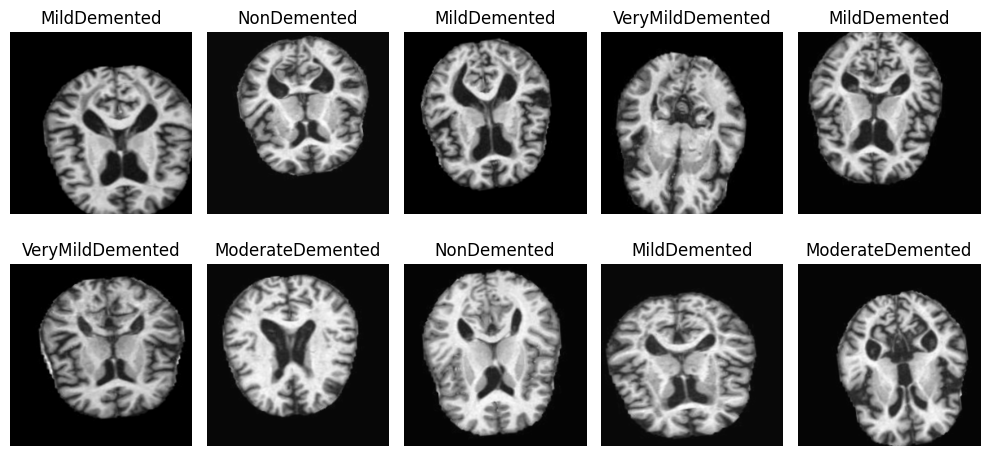

In [9]:

# Define the labels corresponding to their numeric representations
label_mapping = {
    0: 'MildDemented',
    1: 'ModerateDemented',
    2: 'NonDemented',
    3: 'VeryMildDemented'
}

# Define the number of images to display
num_images = 10

# Create a subplot with 2 rows and 5 columns
plt.figure(figsize=(10, 5))
for i in range(num_images):
    # Get the image and its corresponding label
    img = X_train[i]
    label_numeric = y_train[i]
    label_text = label_mapping[label_numeric]

    # Plot the image
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
    plt.imshow(img)
    plt.title(f"{label_text}")  # Set title as label
    plt.axis('off')  # Turn off axis labels

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [10]:
from keras import backend as K

# Define the number of color channels in the images
IMG_CHANNELS = 3

# Define the width and height of the images
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Check the image data format convention
if K.image_data_format() == 'channels_first':
    # If the data format is 'channels_first', set the input shape accordingly
    input_shape = (IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT)
else:
    # If the data format is 'channels_last', set the input shape accordingly
    input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

In [12]:
test_data_path= '/content/drive/MyDrive/Alzheimer_s Dataset/test/'


all_test_data=[]
all_test_label=[]


# Loop through each label
for label in labels:
    print(label)

    # Get the list of image filenames for the current label
    test_img_filenames = [f for f in os.listdir(test_data_path + '/' + label) if f.endswith('.jpg')]

    # Loop through each image filename
    for img_filename in test_img_filenames:
        # Read the image using OpenCV
        img = cv2.imread(test_data_path + '/' + label + '/' + img_filename)

        # Convert the image to RGB format
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize the image to (224, 224) pixels
        img_resized = cv2.resize(img_rgb, (224, 224))

        # Append the resized image and its label to the lists
        all_test_data.append(img_resized)
        all_test_label.append(label)

VeryMildDemented
MildDemented
ModerateDemented
NonDemented


In [13]:
# Count occurrences of each label in test data
label_counts = Counter(all_test_label)

# Print label counts
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: VeryMildDemented, Count: 448
Label: MildDemented, Count: 179
Label: ModerateDemented, Count: 12
Label: NonDemented, Count: 640


In [14]:
# Convert the list of images to a numpy array
X_test = np.array(all_test_data)

# Convert the list of labels to a numpy array
y_test = np.array(all_test_label)

# Define label mapping for y_test
label_mapping_test = {
    'MildDemented':0 ,
    'ModerateDemented':1 ,
    'NonDemented':2 ,
    'VeryMildDemented':3
}

# Map numeric labels in y_test to their corresponding text labels
y_test= np.array([label_mapping_test[label] for label in y_test])

# Check the shape of the arrays
print("Shape of X_test (image data):", X_test.shape)
print("Shape of y_test (labels):", y_test.shape)

Shape of X_test (image data): (1279, 224, 224, 3)
Shape of y_test (labels): (1279,)


In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16
import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

## Parametreler
NOISE_DIM = 100
BATCH_SIZE = 4
STEPS_PER_EPOCH = 3750
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 224,224,3

OPTIMIZER = Adam(0.0002, 0.5)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU

def build_generator():
    """
    Generator model "generates" images using random noise. The random noise AKA Latent Vector
    is sampled from a Normal Distribution which is given as the input to the Generator. Using
    Transposed Convolution, the latent vector is transformed to produce an image
    We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
    of Convolutional Learning)

    Input: Random Noise / Latent Vector
    Output: Image
    """

    model = Sequential([
        Dense(22*26*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((22, 26, 256)),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(64, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(CHANNELS, (4, 4), strides=2, padding='same', activation='tanh')
    ],
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [40]:
def build_discriminator():

    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

In [41]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 224, 224, 64)      0         
                                                                 
 conv2d_41 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 leaky_re_lu_71 (LeakyReLU)  (None, 112, 112, 128)     0         
                                                                 
 conv2d_42 (Conv2D)          (None, 56, 56, 128)       147584    
                                                                 
 leaky_re_lu_72 (LeakyReLU)  (None, 56, 56, 128)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 28, 28, 256)   

In [42]:
import os

def sample_images(noise, subplots, figsize=(22, 8), save=False, save_path="generated_images"):
    generated_images = generator.predict(noise)

    # Create the save directory if it doesn't exist
    if save and not os.path.exists(save_path):
        os.makedirs(save_path)

    plt.figure(figsize=figsize)

    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))

        if save:
            img_name = os.path.join(save_path, f"gen_{i}.png")
            plt.savefig(img_name)
            print(f"Image saved at {img_name}")

        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [73]:
np.random.seed(SEED)
for epoch in range(10):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)

        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)

        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))

  0%|          | 0/3750 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  0%|          | 0/3750 [00:03<?, ?it/s]


KeyError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable dense_21/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'
